# Whole process
This notebook shows the process of finding point of radial mode.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
import xlrd

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict
from sklearn.ensemble import IsolationForest

sys.path.insert(0, os.path.join('..'))

from radial import calculate_metrics

from radial.batchflow import Dataset, FilesIndex, Pipeline, B
from radial.batchflow.models.tf import ResNet

from radial.core import RadialBatch
from radial.core import calculate_results
from radial.pipelines import create_preprocess_pipeline,\
                             create_train_pipeline,\
                             create_predict_pipeline
from radial.preprocessing import drop_outliers, xls_to_npz

plt.style.use('ggplot')
%matplotlib inline

## 1. Preprocessing.
#### 1.1. Raw data to NPZ.

Files with train/test split

In [3]:
xls_to_npz(path_from=['./test_90.xlsx', './train_311.xlsx'],
           path_to=['./data_splited/test', './data_splited/train'])

Done!


The same files without splitting

In [4]:
xls_to_npz(path_from=['./test_90.xlsx', './train_311.xlsx'],
           path_to=['./data'])

Done!


## 1.2. Removing outliers from data using Isolation Forest.

Applying the method to data for training and testing

In [5]:
drop_outliers(path_from=['data_splited/train', 'data_splited/test'],
              path_to=['data_splited/train_isol', 'data_splited/test_isol'], rewrite=True)

100%|██████████| 90/90 [00:10<00:00,  8.36it/s]

Done!


## 2. Training process

Config creation:

In [6]:
N_SAMPLES = 100

model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [4, 8, 16],
    'initial_block/filters': 4,
    'loss': 'mse',
    'optimizer': 'Adam'
}

Load the data and create Dataset objects.

In [7]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)

Create two pipelines and run training process

In [8]:
prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(ResNet, model_config, prep_pipeline) << ds_train

In [9]:
train_pipeline.run(50, n_epochs=300, drop_last=True, shuffle=True, bar=True)

100%|██████████| 1800/1800 [04:22<00:00,  6.89it/s]


## 3. Evaluation
Firstly create a predict pipeline and run it

In [10]:
test_pipeline = create_predict_pipeline(prep_pipeline, train_pipeline) << ds_test

In [11]:
test_pipeline.run(1, n_epochs=10, drop_last=True, bar=True)

100%|█████████▉| 899/900 [00:07<00:00, 127.57it/s]


Calculate statistics and plot the histogram of MAPE error.

In [12]:
results, _ = calculate_results(test_pipeline)

In [13]:
true = []
pred = []
for key in results.keys():
    results[key]['pred'] = np.mean(results[key]['pred'])
    true.append(results[key]['true'][0])
    pred.append(results[key]['pred'])

MAE: 0.178
MAPE: 0.1133
Percentage of error less than 30%: 93.33%


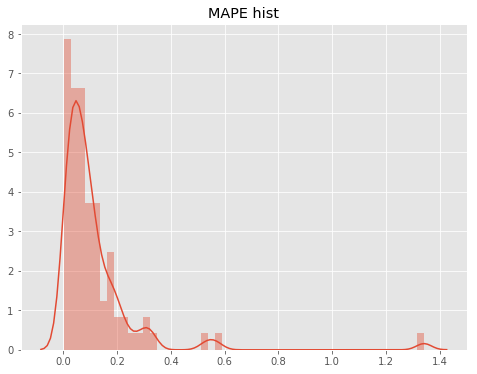

In [14]:
calculate_metrics(np.array(true), np.array(pred), 50)